In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")

In [4]:
df_train = pd.read_csv(r"/content/train_clf.csv")

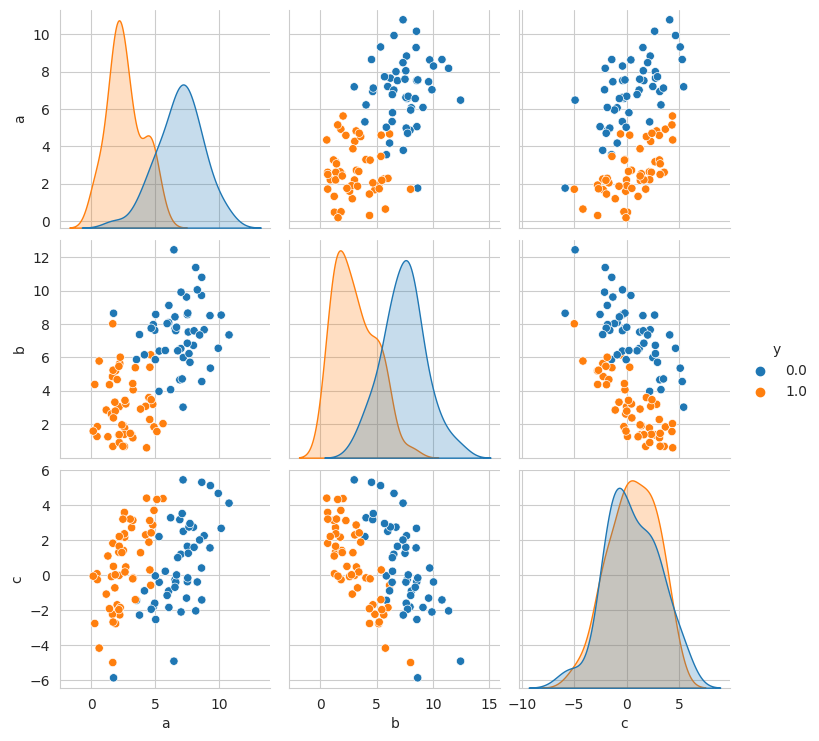

In [5]:
sns.pairplot(df_train, hue='y', diag_kind='kde');

In [6]:
columns = ['a', 'b', 'c']
x_0 = df_train[columns].values
y_0 = df_train['y']

In [7]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sigma=20, shape=2)
    σ = pm.HalfNormal('σ', 10, shape=2)
    y_00= pm.Normal('y_0', mu=μ[0], sigma=σ[0], observed=x_0[:50])
    y_1 = pm.Normal('y_1', mu=μ[1], sigma=σ[1], observed=x_0[50:])

    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(2000, chains = 4, cores = 4)

Text(0.5, 0, 'с')

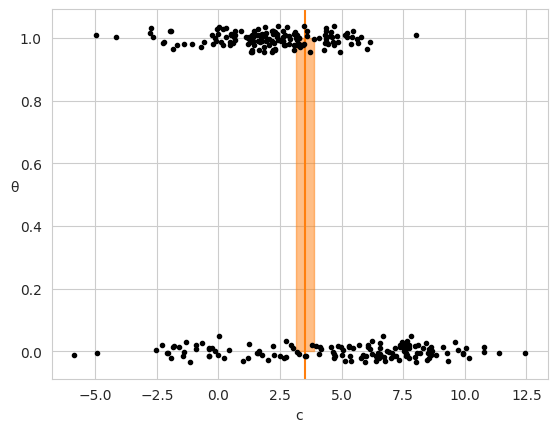

In [8]:
posterior_lda = trace_lda.posterior.stack(samples=("chain", "draw"))

plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('с')

In [9]:
az.summary(trace_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],3.622,0.277,3.102,4.150,0.002,0.002,13499.0,6646.0,1.0
μ[1],3.371,0.277,2.869,3.911,0.002,0.002,14142.0,6016.0,1.0
σ[0],3.363,0.201,2.990,3.744,0.002,0.001,13737.0,6559.0,1.0
σ[1],3.419,0.201,3.056,3.808,0.002,0.001,12064.0,6180.0,1.0
bd,3.497,0.196,3.142,3.876,0.002,0.001,13529.0,6683.0,1.0


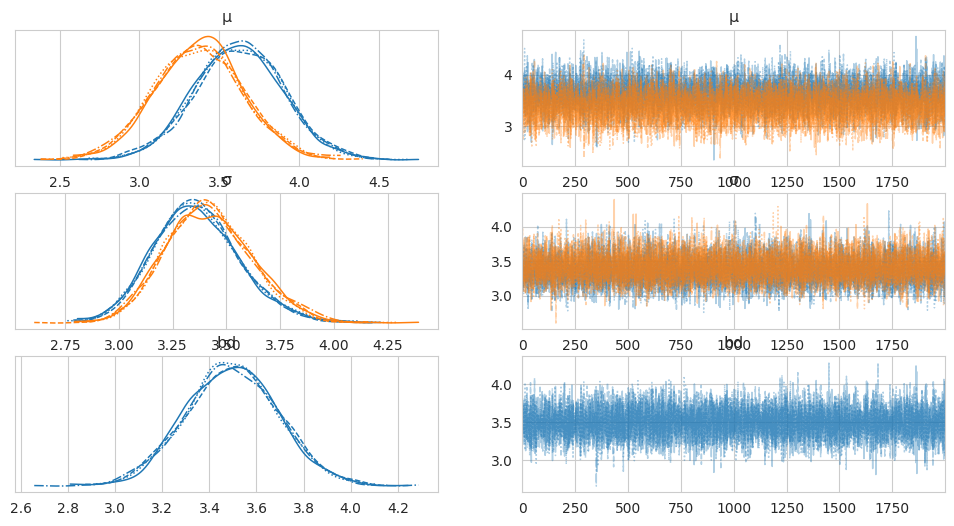

In [10]:
az.plot_trace(trace_lda,compact=True);

In [11]:
df_test = pd.read_csv(r"/content/test_clf.csv")

In [31]:
columns = ['a','b','c']
X_test = df_test[columns]
X_test_transformed = StandardScaler().fit_transform(X_test)

In [34]:
predict = [1 if i < posterior_lda['bd'].mean() else 0 for i in X_test_transformed.sum(axis=1)]